In [178]:
import sys    
import csv    
import matplotlib.pyplot as plt    
from matplotlib.backends.backend_pdf import PdfPages    
import polars as pl   
import seaborn as sns    
from os.path import basename    

col = pl.col    

In [204]:
data1 = "out.csv"
# traces_num is the number of traces for which the monitor found a violation of OD
# (or the highest tested number of traces if the monitor hasn't found a violation)
df = pl.read_csv(data1, separator=r' ', null_values=["None", "nan"],
                 new_columns=["mon", "n_ops", "n_prods", "n_cons", "t_dir", "t_name", "t_len", "backtr",
                          "verdict", "cputime", "walltime", "mem", "retcode", "traces_id"])
TIMEOUT=30
df

shape: (2_969, 14)
┌─────────────┬───────┬─────────┬────────┬───┬──────────┬───────────┬─────────┬────────────┐
│ mon         ┆ n_ops ┆ n_prods ┆ n_cons ┆ … ┆ walltime ┆ mem       ┆ retcode ┆ traces_id  │
│ ---         ┆ ---   ┆ ---     ┆ ---    ┆   ┆ ---      ┆ ---       ┆ ---     ┆ ---        │
│ str         ┆ i64   ┆ i64     ┆ i64    ┆   ┆ f64      ┆ f64       ┆ i64     ┆ i64        │
╞═════════════╪═══════╪═════════╪════════╪═══╪══════════╪═══════════╪═════════╪════════════╡
│ mon         ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0.02     ┆ 5.0234375 ┆ 0       ┆ 1381145607 │
│ mon         ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0.0      ┆ 3.980469  ┆ 0       ┆ 1381145607 │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0.03     ┆ 5.003906  ┆ 0       ┆ 1381145607 │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0.02     ┆ 5.0       ┆ 0       ┆ 1381145607 │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0.0      ┆ 4.066406  ┆ 0       ┆ 1381145607 │
│ …           ┆ …     ┆ …       ┆ …      ┆ … ┆ …        ┆ …         ┆ …       ┆ …          │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 19.73    ┆ 83.421875 ┆ 1       ┆ 1381145607 │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 13.16    ┆ 83.578125 ┆ 1       ┆ 1381145607 │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 20.49    ┆ 83.90625  ┆ 1       ┆ 1381145607 │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 13.1     ┆ 83.675781 ┆ 1       ┆ 1381145607 │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 10.53    ┆ 83.675781 ┆ 1       ┆ 1381145607 │
└─────────────┴───────┴─────────┴────────┴───┴──────────┴───────────┴─────────┴────────────┘

In [205]:
labels_map = {
    "mon": "Lin.",
    "mon-legal": "Lin. + legal",    
    "mon-bounded": "Lin. + bounded",    
}

def name_labels(legend, vals=labels_map):
    legend.set_title("")
    labels = legend.texts
    for l in labels:
        l.set_text(vals.get(l.get_text(), l.get_text()))

In [214]:
D = df.with_columns(time=pl.when(col("t_len").is_null()).then(TIMEOUT).otherwise(col("cputime")))
D = D.with_columns(ver=pl.when(col("t_len").is_null()).then(pl.lit("to")).otherwise(col("verdict").cast(pl.String)))
D

shape: (2_969, 16)
┌─────────────┬───────┬─────────┬────────┬───┬─────────┬────────────┬───────┬───────┐
│ mon         ┆ n_ops ┆ n_prods ┆ n_cons ┆ … ┆ retcode ┆ traces_id  ┆ time  ┆ ver   │
│ ---         ┆ ---   ┆ ---     ┆ ---    ┆   ┆ ---     ┆ ---        ┆ ---   ┆ ---   │
│ str         ┆ i64   ┆ i64     ┆ i64    ┆   ┆ i64     ┆ i64        ┆ f64   ┆ str   │
╞═════════════╪═══════╪═════════╪════════╪═══╪═════════╪════════════╪═══════╪═══════╡
│ mon         ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0       ┆ 1381145607 ┆ 0.02  ┆ true  │
│ mon         ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0       ┆ 1381145607 ┆ 30.0  ┆ to    │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0       ┆ 1381145607 ┆ 0.02  ┆ true  │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0       ┆ 1381145607 ┆ 0.02  ┆ true  │
│ mon-legal   ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 0       ┆ 1381145607 ┆ 30.0  ┆ to    │
│ …           ┆ …     ┆ …       ┆ …      ┆ … ┆ …       ┆ …          ┆ …     ┆ …     │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 1       ┆ 1381145607 ┆ 19.54 ┆ false │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 1       ┆ 1381145607 ┆ 13.08 ┆ false │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 1       ┆ 1381145607 ┆ 20.3  ┆ false │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 1       ┆ 1381145607 ┆ 13.02 ┆ false │
│ mon-bounded ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 1       ┆ 1381145607 ┆ 10.46 ┆ false │
└─────────────┴───────┴─────────┴────────┴───┴─────────┴────────────┴───────┴───────┘

In [215]:
#D = D.group_by(col("mon"), col("n_ops"), col("n_prods"), col("n_cons"), col("t_dir"), col("t_name"), col("t_len"), col("backtr"))\
#        .agg(col("verdict").first(), col("verdict").n_unique().alias("unique_verdict") <= 1, col("cputime").mean())\
#        .filter(col("unique_verdict"))
D = D.group_by(col("mon"), col("n_ops"), col("n_prods"), col("n_cons"), col("t_dir"), col("t_name"))\
        .agg(col("ver").first(), col("ver").n_unique().alias("unique_verdict") <= 1, col("time").mean())\
        .filter(col("unique_verdict"))
fdf = D
D

shape: (802, 9)
┌─────────────┬───────┬─────────┬────────┬───┬─────────┬───────┬────────────────┬───────────┐
│ mon         ┆ n_ops ┆ n_prods ┆ n_cons ┆ … ┆ t_name  ┆ ver   ┆ unique_verdict ┆ time      │
│ ---         ┆ ---   ┆ ---     ┆ ---    ┆   ┆ ---     ┆ ---   ┆ ---            ┆ ---       │
│ str         ┆ i64   ┆ i64     ┆ i64    ┆   ┆ str     ┆ str   ┆ bool           ┆ f64       │
╞═════════════╪═══════╪═════════╪════════╪═══╪═════════╪═══════╪════════════════╪═══════════╡
│ mon-legal   ┆ 500   ┆ 2       ┆ 2      ┆ … ┆ 32.csv  ┆ true  ┆ true           ┆ 3.05      │
│ mon-bounded ┆ 800   ┆ 2       ┆ 2      ┆ … ┆ 38.csv  ┆ false ┆ true           ┆ 11.923333 │
│ mon         ┆ 900   ┆ 2       ┆ 2      ┆ … ┆ 100.csv ┆ true  ┆ true           ┆ 16.41     │
│ mon         ┆ 200   ┆ 2       ┆ 2      ┆ … ┆ 4.csv   ┆ true  ┆ true           ┆ 0.17      │
│ mon-legal   ┆ 700   ┆ 2       ┆ 2      ┆ … ┆ 113.csv ┆ true  ┆ true           ┆ 7.856667  │
│ …           ┆ …     ┆ …       ┆ …      ┆ … ┆ …       ┆ …     ┆ …              ┆ …         │
│ mon         ┆ 100   ┆ 2       ┆ 2      ┆ … ┆ 144.csv ┆ true  ┆ true           ┆ 0.02      │
│ mon-bounded ┆ 500   ┆ 2       ┆ 2      ┆ … ┆ 62.csv  ┆ true  ┆ true           ┆ 2.996667  │
│ mon         ┆ 1000  ┆ 2       ┆ 2      ┆ … ┆ 129.csv ┆ true  ┆ true           ┆ 22.273333 │
│ mon-bounded ┆ 300   ┆ 2       ┆ 2      ┆ … ┆ 111.csv ┆ false ┆ true           ┆ 0.686667  │
│ mon         ┆ 800   ┆ 2       ┆ 2      ┆ … ┆ 149.csv ┆ true  ┆ true           ┆ 11.773333 │
└─────────────┴───────┴─────────┴────────┴───┴─────────┴───────┴────────────────┴───────────┘

In [262]:
D = fdf
#D = datait.fillna({"verdict": "TO", "cputime": TIMEOUT + 2})

D = D.select(col("mon"), col("n_ops"), col("n_prods"), col("n_cons"),  col("time"))
D = D.filter(col("n_prods") == 2, col("n_cons") == 2)
D = D.group_by(col("mon"), col("n_ops"), col("n_prods"), col("n_cons")).agg(
    #col("t_len").mean(),
    #col("backtr").mean(),
    col("time").mean()
)
D = D.sort("n_ops", "mon")


nums = {}
lens = set()
for r in D.rows():
    nums.setdefault(r[0], {})[r[1]] = r[4]
    lens.add(int(r[1]))
    #print(r)
    # print(f'{r[0]:<15} {r[1]:<4} {r[4]:<5.2f}')

lens = [l for l in lens if l % 200 == 0]
lens.sort()

#print(nums)
with open('tab-lin.tex', 'w') as f:
    print("\\begin{tabular}{l" + "r"*len(lens) + "}", file=f)
    print("\\toprule", file=f)
    print('Monitor', end=" & ", file=f)
    print(' & '.join(map(str, lens)), end="", file=f)
    print("\\\\", file=f)
    print("\\midrule", file=f)
    for mon in ("mon", "mon-legal", "mon-bounded"):
        vals = nums[mon]
        print(f'\\textit{{{labels_map[mon]}}}', end=" ", file=f)
        for l in lens:
            print(f'& {vals[l]:<5.2f}', end=" ", file=f)
        print("\\\\", file=f)
    print("\\bottomrule", file=f)
    print("\\end{tabular}", file=f)


In [258]:
D = fdf
Dm = D.join(D, on=("t_dir", "t_name", "n_ops", "n_prods", "n_cons"))


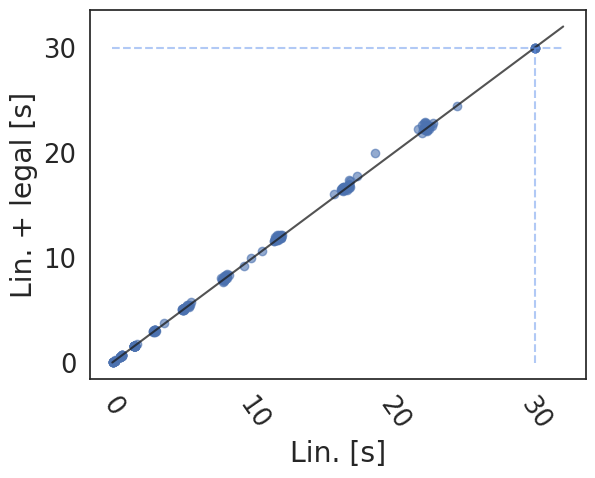

In [260]:
sns.set()
sns.set_theme(style="white", font_scale=1.7,)

# fix, axs = plt.subplots(1, 1, figsize=(8,4))

#D = Dm[(Dm["mon"] == "mon") & (Dm["mon_y"] == "mon-legal")]
D = Dm.filter(col("mon") == "mon", col("mon_right") == "mon-legal")
#D = D[D["n_ops"] < 800]
x, y = D.select(col("time")), D.select(col("time_right"))
g = plt.scatter(x, y, marker='o', alpha=0.6)

# plt.scatter(D["cputime_antichains"], D["cputime_bool"],
#            marker='o', color="orange", alpha=0.6)


#plt.yscale('symlog')
#plt.xscale("log")
#g.set_axis_labels("Input length", "Number of traces")
#g.legend().set_title("Monitor")
# name_labels(g.legend())

plt.xlabel("Lin. [s]")
plt.ylabel("Lin. + legal [s]")
plt.xticks(rotation=-55)

#g.set_aspect('equal')

MAXTIME=TIMEOUT + 2
plt.plot([0, MAXTIME], [0, MAXTIME], 'k-', alpha=0.75)
plt.plot([0, MAXTIME], [TIMEOUT, TIMEOUT], '--', alpha=0.5, color="cornflowerblue")
plt.plot([TIMEOUT, TIMEOUT], [0, TIMEOUT], '--', alpha=0.5, color="cornflowerblue")


# plt.savefig('cputime-mon-mon-legal.pdf',bbox_inches='tight', dpi=600)

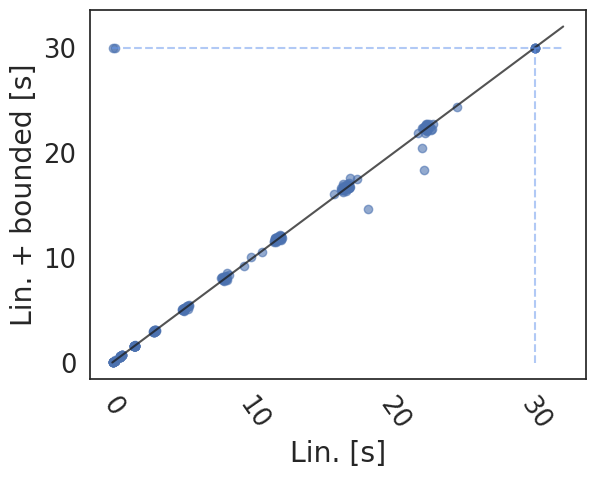

In [261]:
sns.set()
sns.set_theme(style="white", font_scale=1.7,)

# fix, axs = plt.subplots(1, 1, figsize=(8,4))

#D = Dm[(Dm["mon"] == "mon") & (Dm["mon_y"] == "mon-legal")]
D = Dm.filter(col("mon") == "mon", col("mon_right") == "mon-bounded")
x, y = D.select(col("time")), D.select(col("time_right"))
g = plt.scatter(x, y, marker='o', alpha=0.6)

# plt.scatter(D["cputime_antichains"], D["cputime_bool"],
#            marker='o', color="orange", alpha=0.6)


#plt.yscale('symlog')
#plt.xscale("log")
#g.set_axis_labels("Input length", "Number of traces")
#g.legend().set_title("Monitor")
# name_labels(g.legend())

plt.xlabel("Lin. [s]")
plt.ylabel("Lin. + bounded [s]")
plt.xticks(rotation=-55)

#g.set_aspect('equal')

MAXTIME=TIMEOUT + 2
plt.plot([0, MAXTIME], [0, MAXTIME], 'k-', alpha=0.75)
plt.plot([0, MAXTIME], [TIMEOUT, TIMEOUT], '--', alpha=0.5, color="cornflowerblue")
plt.plot([TIMEOUT, TIMEOUT], [0, TIMEOUT], '--', alpha=0.5, color="cornflowerblue")


# plt.savefig('cputime-mon-mon-legal.pdf',bbox_inches='tight', dpi=600)

In [ ]:

D = Dm[(Dm["mon_x"] == "mon") & (Dm["mon_y"] == "mon-bounded")]
D[D["cputime_x"] > D["cputime_y"]]